In [61]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

import matplotlib.pyplot as plt

import numpy as np
import scipy.integrate
import scipy.optimize
import math
import time
from utils import *

In [291]:
def h(alpha, a, s1, s2):
    return ((alpha**2 * s2 + alpha * a * s2 ** 2 + a**2 * s2**3 / 3) -
            (alpha**2 * s1 + alpha * a * s1 ** 2 + a**2 * s1**3 / 3))

def h3(alpha, a, b, s1, s2):
    return (
        (alpha**2 * s2 + a**2 * s2**3 / 3 + b**2 * s2**5 / 5 + alpha*a * s2**2 + 2*alpha * s2**3 / 3 + 2*a*b* s2**4 / 4) -
        (alpha**2 * s1 + a**2 * s1**3 / 3 + b**2 * s1**5 / 5 + alpha*a * s1**2 + 2*alpha * s1**3 / 3 + 2*a*b* s1**4 / 4)
    )

def s_factory_factory(vec_z):
    # vec_z =    # j = 0..J
    vec_del_z = vec_z[1:] - vec_z[:-1] # j = 0..J-1
    
    def s_factory(theta): # args = theta, each j = 0..J
        ##beta0 = theta[0]
        ##beta1 = theta[1]
        ##vec_b = theta[2:]
        beta0 = theta[0]
        beta1 = theta[1]
        beta2 = theta[2]
        vec_b = theta[3:(2+len(vec_z))]
        vec_c = theta[(2+len(vec_z)):]
        ## done

        ##vec_alpha = np.hstack((beta0, beta0 - np.cumsum(vec_b * vec_z[1:])))
        ##vec_a = np.hstack((beta1, beta1 + np.cumsum(vec_b)))
        vec_alpha = np.hstack((beta0, beta0 - np.cumsum(vec_b * vec_z[1:] + vec_c * vec_z[1:]**2)))
        vec_a = np.hstack((beta1, beta1 + np.cumsum(vec_b - vec_c * vec_z[1:])))
        vec_A = np.hstack((beta2, beta2 + np.cumsum(vec_c)))
        ## done
        
        ##vec_h = h(vec_alpha, vec_a, vec_z, np.hstack((vec_z[1:],[1.0]))) # j = 0..J
        vec_h = h3(vec_alpha, vec_a, vec_A, vec_z, np.hstack((vec_z[1:],[1.0]))) # j = 0..J
        ## done
        vec_H = np.cumsum(vec_h) # j = 0..J
        vec_exp_H = np.exp(vec_H)
        vec_sum_H = np.cumsum(vec_H) # j = 0..J
        
        vec_exp_sum_H = np.exp(vec_sum_H) # j = 0..J
        vec_del_z_exp_sum_H = vec_del_z * vec_exp_sum_H[:-1]
        vec_sum_del_z_exp_sum_H = np.cumsum(vec_del_z_exp_sum_H)
        
        vec_term1_parts = np.empty(len(vec_z))
        for j in range(len(vec_z)-1):
            ##integrand = lambda s: math.exp(h(vec_alpha[j], vec_a[j], vec_z[j], s))
            integrand = lambda s: math.exp(h3(vec_alpha[j], vec_a[j], vec_A[j], vec_z[j], s))
            ## done
            vec_term1_parts[j] = ((vec_exp_H[j-1] if j > 0 else 1) *
                                  (scipy.integrate.quad(integrand, vec_z[j], vec_z[j+1]))[0])
        vec_term1 = np.cumsum(vec_term1_parts)
            

        def s(u):
            if u < 0:
                #print("Negative u requested", u)
                return 0
            
            Ju = np.argmax((vec_z - u)[vec_z <= u])

            #integrand = lambda s: math.exp(h(alpha_Ju, a_Ju, z_Ju, s))
            #integral = scipy.integrate.quad(integrand, z_Ju, u)[0]
            #term2 = vec_exp_sum_H[Ju] * integral

            #term1 = (vec_sum_del_z_exp_sum_H[Ju-1] if Ju > 0 else 0)
            #term1 = 0
            #for j in range(0, Ju):
            #    integrand = lambda s: math.exp(h(vec_alpha[j], vec_a[j], vec_z[j], s))
            #    term1 += ((vec_exp_H[j-1] if j > 0 else 1) *
            #              (scipy.integrate.quad(integrand, vec_z[j], vec_z[j+1]))[0])
            term1 = vec_term1[Ju-1] if Ju > 0 else 0
            
            ##integrand = lambda s: math.exp(h(vec_alpha[Ju], vec_a[Ju], vec_z[Ju], s))
            integrand = lambda s: math.exp(h3(vec_alpha[Ju], vec_a[Ju], vec_A[Ju], vec_z[Ju], s))
            ## done
            term2 = (vec_exp_H[Ju-1] if Ju > 0 else 1) * scipy.integrate.quad(integrand, vec_z[Ju], u)[0]
                        
            result = term1 + term2

            return result
                
        return np.vectorize(s)
    return s_factory

def lorenz_factory(s):
    s1 = s(1)
    return lambda u: s(u) / s1

def objective_factory(vec_z, vec_s):
    s_factory = s_factory_factory(vec_z)
    
    def objective(theta):        
        s = s_factory(theta)
        
        error = vec_s - lorenz_factory(s)(vec_z)
        return np.sum(error * error)
    return objective

$$
(\alpha + a x + b x^2)^2 = \alpha^2 + a^2 x^2 +  b^2 x^4 + 2 \alpha a x + 2 \alpha b x^2 + 2 a b x^3
$$
integral
$$
\alpha^2 x + a^2 x^3 / 3 + b^2 x^5 / 5 + \alpha a x^2 + 2 \alpha  x^3 / 3 + 2 a b x^4 / 4
$$



def m1(t, vec_z, theta):
    vec_alpha = theta[0:len(theta)//2]
    vec_a     = theta[len(theta)//2:]
    #vec_alpha = theta[0:len(theta)//3]
    #vec_a     = theta[len(theta)//3:2*len(theta)//3]
    #vec_b     = theta[2*len(theta)//3:]
    beta0 = theta[0]
    beta1 = theta[1]
    vec_b = theta[2:]

    return beta0 + beta1 + np.sum((vec_b * (t - vec_z[1:]))[t > vec_z[1:]])

def integral1(s, vec_z, theta):
    integrand = lambda t: (m1(t, vec_z, theta))**2
    return scipy.integrate.quad(integrand, 0, s)[0]

def s2_factory(vec_z, theta):
    def s2(u):
        integrand = lambda s: math.exp(integral1(s, vec_z, theta))
        return scipy.integrate.quad(integrand, 0, u)[0]
    return np.vectorize(s2)

def lorenz_factory(s):
    s1 = s(1)
    return lambda u: s(u) / s1

def objective2_factory(vec_z, vec_s):
    def objective(theta):
        s2 = s2_factory(vec_z, theta)
        error = vec_s - lorenz_factory(s2)(vec_z)
        return np.sum(error * error)
    return objective

In [298]:
#Indo - min 22 mean 133 = 0.17 slope
p = np.array([0.0, 2.4968789013732834e-05, 0.010038, 0.02002, 0.030029, 0.040013, 0.090013999999999997, 0.14005000000000001, 0.19003, 0.24002000000000001, 0.29014000000000001, 0.34003, 0.39001999999999998, 0.44001000000000001, 0.49003000000000002, 0.54005000000000003, 0.59003000000000005, 0.64005000000000001, 0.68999999999999995, 0.74004000000000003, 0.79000000000000004, 0.83999999999999997, 0.89000000000000001, 0.94003000000000003, 0.99000999999999995])
L = np.array([0.0, 4.1776197942857322e-06, 0.0027583999999999998, 0.0059572999999999996, 0.0094094000000000001, 0.013046, 0.033440999999999999, 0.056544999999999998, 0.081741999999999995, 0.10892, 0.13805000000000001, 0.16905999999999999, 0.20247999999999999, 0.23838000000000001, 0.27700999999999998, 0.31847999999999999, 0.36293999999999998, 0.41088000000000002, 0.46260000000000001, 0.51895000000000002, 0.58048999999999995, 0.64817999999999998, 0.72431000000000001, 0.81459000000000004, 0.94091999999999998])
#
#Brazil
#p = np.array([0.0, 5.0057566201131301e-05, 0.014407, 0.020039999999999999, 0.029999999999999999, 0.040009000000000003, 0.090017, 0.14002999999999999, 0.19001000000000001, 0.24104999999999999, 0.29000999999999999, 0.34000999999999998, 0.39268999999999998, 0.44002000000000002, 0.49020000000000002, 0.54000000000000004, 0.59003000000000005, 0.64007000000000003, 0.69001000000000001, 0.74775000000000003, 0.7903, 0.84055999999999997, 0.89017000000000002, 0.94025999999999998, 0.99051999999999996])
#L = np.array([0.0, 0.0, 0.0, 0.00015632999999999999, 0.00064271, 0.0013722000000000001, 0.0079450000000000007, 0.017760000000000001, 0.030047000000000001, 0.045176000000000001, 0.062114999999999997, 0.081788, 0.10553999999999999, 0.12956000000000001, 0.15811, 0.19009999999999999, 0.22564000000000001, 0.26451999999999998, 0.30784, 0.36535000000000001, 0.41399000000000002, 0.48131000000000002, 0.56291999999999998, 0.67522000000000004, 0.88526000000000005])

#p = np.array([0.0,0.1,0.2,0.3,0.4,0.8])
#L = p*p

objective = objective_factory(p, L)
#objective = objective2_factory(p, L)
np.random.seed(int(time.time()))
#init_theta = np.random.random(len(p)*2)
init_theta = np.random.random(3 + (len(p)-1)*2)
result = scipy.optimize.minimize(objective, init_theta, options={"maxiter": 5000, 'gtol': 1e-5}) # , 
theta = result["x"]
#result

(0, 1)

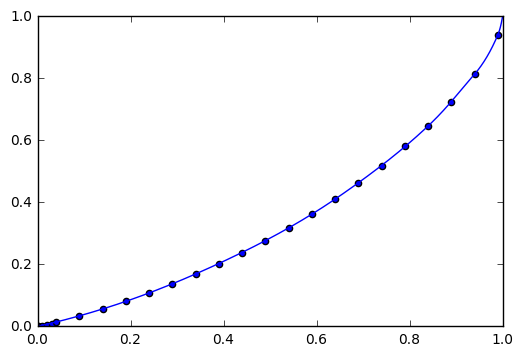

In [307]:
theta = result["x"]
s = s_factory_factory(p)(theta)
#s = s2_factory(p, theta)
Lorenz = lorenz_factory(s)
lower = 0
upper = 1
xgrid = np.linspace(lower,upper,10000)
plt.plot(xgrid, Lorenz(xgrid))
plt.scatter(p,L)
#plt.vlines(x=0.1,ymin=0,ymax=1)
plt.xlim(lower,upper)
plt.ylim(0,1)

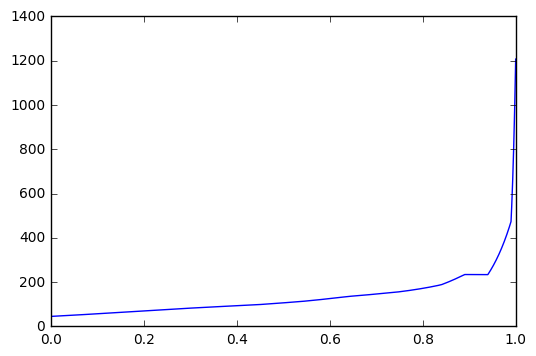

In [308]:
quantile = lambda p: 133 * derivative(Lorenz)(p)
plt.plot(xgrid, quantile(xgrid))

(0, 1000)

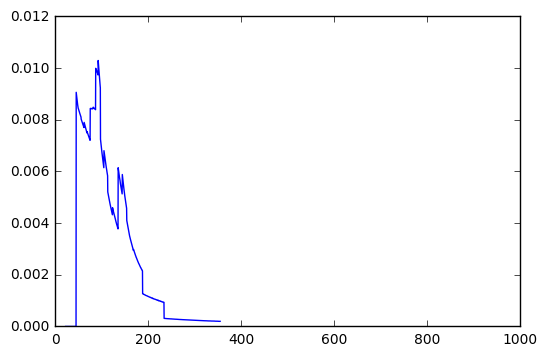

In [309]:
dist = inverse(quantile)
dens = derivative(dist)

ygrid = np.linspace(0, quantile(0.97), 1000)

dens_points = dens(ygrid)
plt.plot(ygrid, dens_points)
plt.xlim(0,1000)